# MobileNetV3 Trash Classification Experiment

This notebook implements a trash classification model using MobileNetV3 architecture. The dataset contains images organized by trash bin colors: Black, Blue, Green, and TTR (possibly "Trash, Recycling, Recycle" or similar).

## 1. Import Required Libraries

In [64]:
import torch
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from PIL import Image
from datetime import datetime
import time
from typing import Dict, Tuple, Optional, Union, Literal, Any

In [65]:
# Set style for better visualizations
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## 2. Dataset Configuration and Paths

In [66]:
# Define dataset paths
dataset_root = Path("../dataset")
train_dir = dataset_root / "CVPR_2024_dataset_Train"
val_dir = dataset_root / "CVPR_2024_dataset_Val"
test_dir = dataset_root / "CVPR_2024_dataset_Test"

# Verify paths exist
print("Dataset directories:")
print(f"Train: {train_dir.exists()} - {train_dir}")
print(f"Val: {val_dir.exists()} - {val_dir}")
print(f"Test: {test_dir.exists()} - {test_dir}")

# Get class names
class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
num_classes = len(class_names)
print(f"\nClasses ({num_classes}): {class_names}")

Dataset directories:
Train: True - ..\dataset\CVPR_2024_dataset_Train
Val: True - ..\dataset\CVPR_2024_dataset_Val
Test: True - ..\dataset\CVPR_2024_dataset_Test

Classes (4): ['Black', 'Blue', 'Green', 'TTR']


## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Statistics

In [67]:
# Count images in each split and class
def count_images(directory: Path) -> dict[str, int]:
    """Count images per class in a directory."""
    class_counts = {}
    for class_dir in sorted(directory.iterdir()):
        if class_dir.is_dir():
            # Count image files (jpg, jpeg, png)
            image_files = (
                list(class_dir.glob("*.jpg"))
                + list(class_dir.glob("*.jpeg"))
                + list(class_dir.glob("*.png"))
            )
            class_counts[class_dir.name] = len(image_files)
    return class_counts

In [68]:
# Get counts for each split
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Display statistics
print("Dataset Statistics:")
print("=" * 60)
print(f"{'Class':<15} {'Train':<12} {'Val':<12} {'Test':<12} {'Total':<12}")
print("-" * 60)

total_train = 0
total_val = 0
total_test = 0

for class_name in class_names:
    train_c = train_counts.get(class_name, 0)
    val_c = val_counts.get(class_name, 0)
    test_c = test_counts.get(class_name, 0)
    total_c = train_c + val_c + test_c

    total_train += train_c
    total_val += val_c
    total_test += test_c

    print(f"{class_name:<15} {train_c:<12} {val_c:<12} {test_c:<12} {total_c:<12}")

print("-" * 60)
print(
    f"{'Total':<15} {total_train:<12} {total_val:<12} {total_test:<12} {total_train + total_val + total_test:<12}"
)
print("=" * 60)

Dataset Statistics:
Class           Train        Val          Test         Total       
------------------------------------------------------------
Black           2382         377          700          3459        
Blue            4856         773          1091         6720        
Green           2331         357          804          3492        
TTR             2116         313          857          3286        
------------------------------------------------------------
Total           11685        1820         3452         16957       


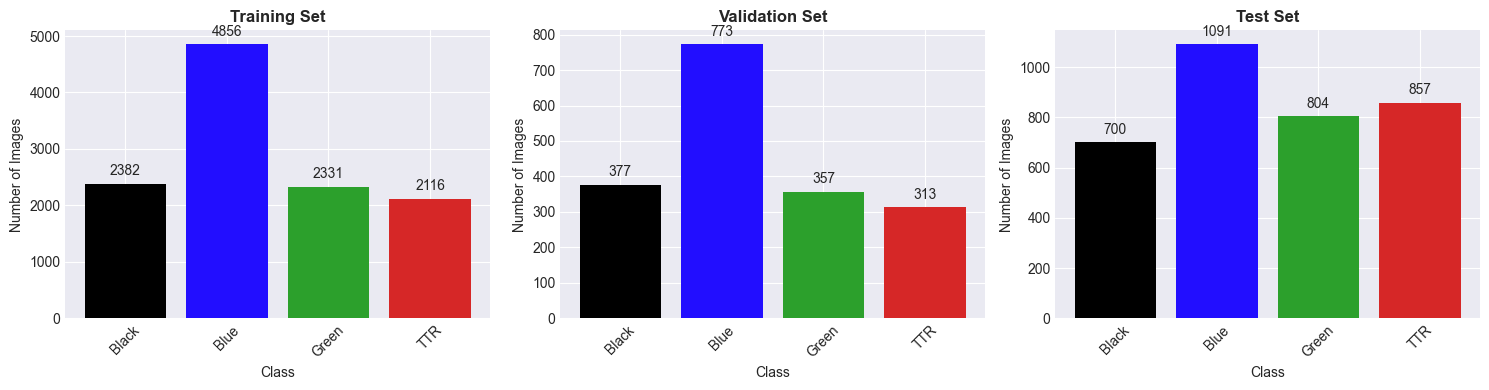


Class Balance Analysis:
Imbalance Ratio (max/min): 2.05
⚠️  Significant class imbalance detected. Consider using weighted loss or data augmentation.


In [69]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets_info = [
    ("Training Set", train_counts),
    ("Validation Set", val_counts),
    ("Test Set", test_counts),
]

for idx, (title, counts) in enumerate(datasets_info):
    classes = list(counts.keys())
    values = list(counts.values())

    axes[idx].bar(classes, values, color=["#000000", "#220eff", "#2ca02c", "#d62727"])
    axes[idx].set_title(title, fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("Class")
    axes[idx].set_ylabel("Number of Images")
    axes[idx].tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for i, v in enumerate(values):
        axes[idx].text(i, v + max(values) * 0.02, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Check for class imbalance
print("\nClass Balance Analysis:")
total_per_class = {
    cls: train_counts.get(cls, 0) + val_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in class_names
}
max_count = max(total_per_class.values())
min_count = min(total_per_class.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float("inf")

print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print(
        "⚠️  Significant class imbalance detected. Consider using weighted loss or data augmentation."
    )

### 3.2 Sample Image Analysis

In [70]:
# Analyze image properties


def analyze_images(
    directory: Path, num_samples=100
) -> tuple[list[int], list[int], list[float], int]:
    """Analyze image dimensions and properties."""
    widths = []
    heights = []
    aspect_ratios = []

    count = 0
    for class_dir in directory.iterdir():
        if class_dir.is_dir():
            image_files = (
                list(class_dir.glob("*.jpg"))
                + list(class_dir.glob("*.jpeg"))
                + list(class_dir.glob("*.png"))
            )

            for img_path in image_files[: num_samples // len(class_names)]:
                try:
                    with Image.open(img_path) as img:
                        w, h = img.size
                        widths.append(w)
                        heights.append(h)
                        aspect_ratios.append(w / h)
                        count += 1
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return widths, heights, aspect_ratios, count


print("Analyzing sample images from training set...")
widths, heights, aspect_ratios, analyzed_count = analyze_images(
    train_dir, num_samples=200
)

print(f"\nAnalyzed {analyzed_count} images")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(
    f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}"
)
print(
    f"Aspect Ratio - Min: {min(aspect_ratios):.2f}, Max: {max(aspect_ratios):.2f}, Mean: {np.mean(aspect_ratios):.2f}"
)

Analyzing sample images from training set...

Analyzed 200 images
Width  - Min: 375, Max: 4032, Mean: 1060.1
Height - Min: 413, Max: 3024, Mean: 1153.0
Aspect Ratio - Min: 0.53, Max: 1.78, Mean: 0.94


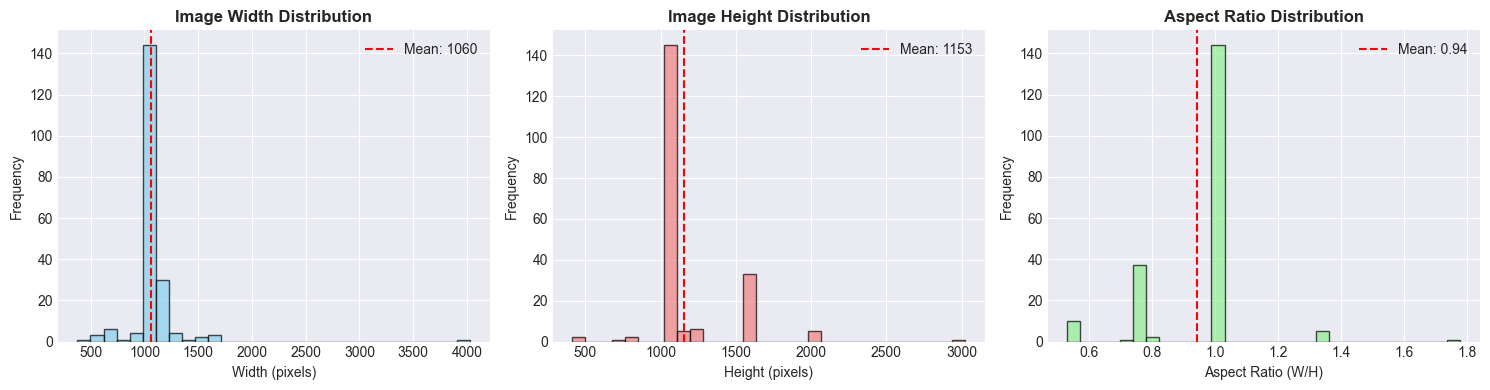

In [71]:
# Visualize image dimension distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Width distribution
axes[0].hist(widths, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Image Width Distribution", fontweight="bold")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Frequency")
axes[0].axvline(
    np.mean(widths), color="red", linestyle="--", label=f"Mean: {np.mean(widths):.0f}"
)
axes[0].legend()

# Height distribution
axes[1].hist(heights, bins=30, color="lightcoral", edgecolor="black", alpha=0.7)
axes[1].set_title("Image Height Distribution", fontweight="bold")
axes[1].set_xlabel("Height (pixels)")
axes[1].set_ylabel("Frequency")
axes[1].axvline(
    np.mean(heights), color="red", linestyle="--", label=f"Mean: {np.mean(heights):.0f}"
)
axes[1].legend()

# Aspect ratio distribution
axes[2].hist(aspect_ratios, bins=30, color="lightgreen", edgecolor="black", alpha=0.7)
axes[2].set_title("Aspect Ratio Distribution", fontweight="bold")
axes[2].set_xlabel("Aspect Ratio (W/H)")
axes[2].set_ylabel("Frequency")
axes[2].axvline(
    np.mean(aspect_ratios),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(aspect_ratios):.2f}",
)
axes[2].legend()

plt.tight_layout()
plt.show()

### 3.3 Visualize Sample Images

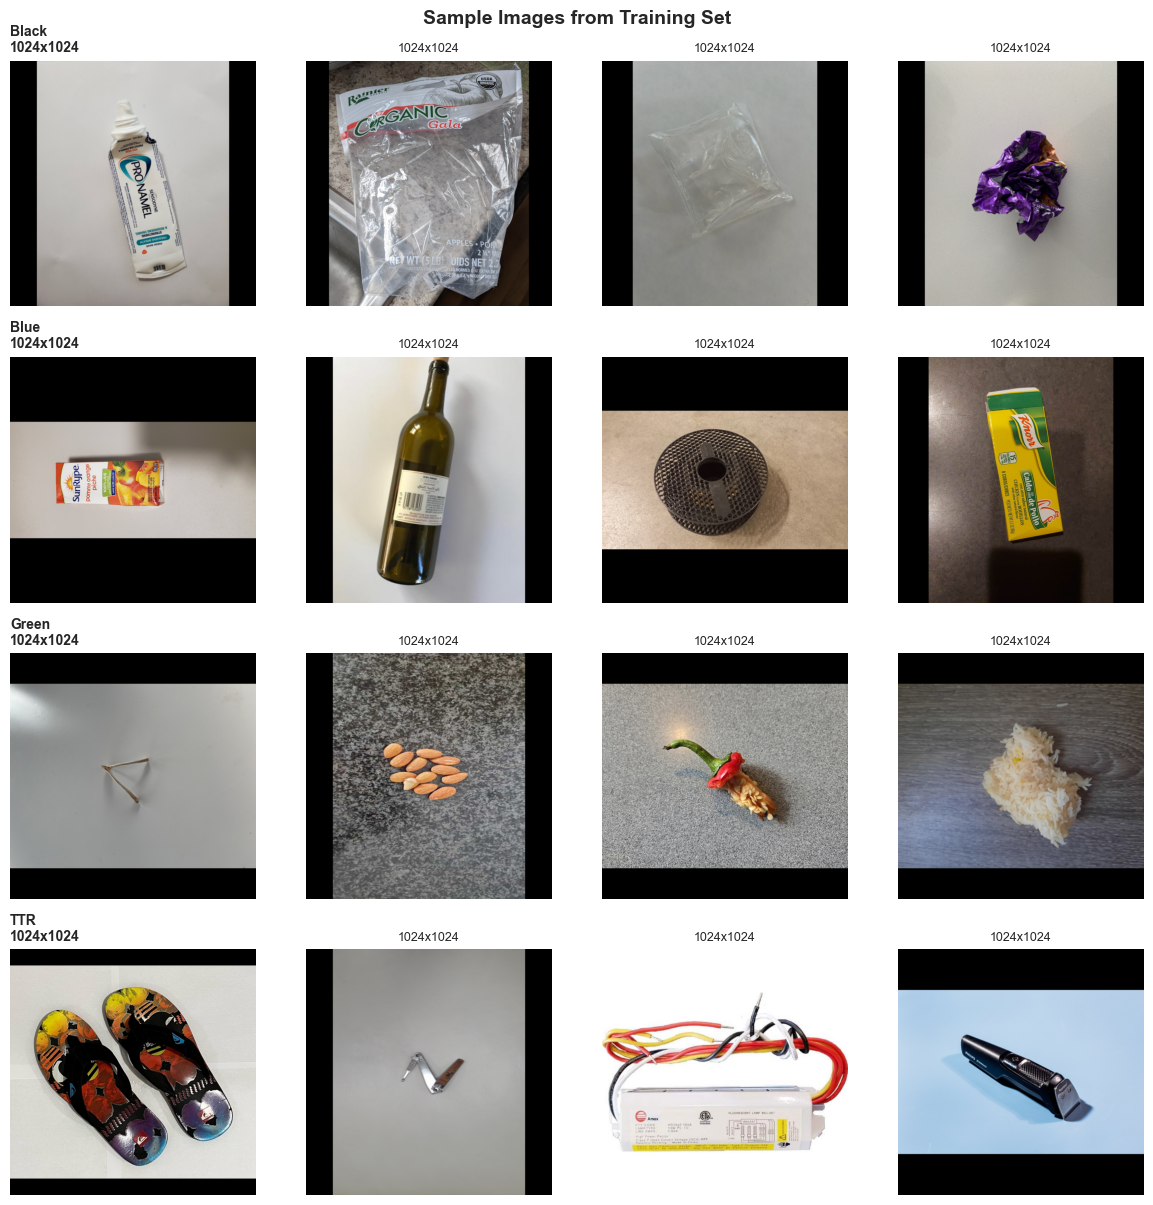

In [72]:
# Display sample images from each class
def show_samples(directory, samples_per_class=4):
    """Display sample images from each class."""
    fig, axes = plt.subplots(
        len(class_names),
        samples_per_class,
        figsize=(samples_per_class * 3, len(class_names) * 3),
    )

    for class_idx, class_name in enumerate(class_names):
        class_dir = directory / class_name
        image_files = (
            list(class_dir.glob("*.jpg"))
            + list(class_dir.glob("*.jpeg"))
            + list(class_dir.glob("*.png"))
        )

        # Get random samples
        np.random.seed(42)  # For reproducibility
        sample_files = np.random.choice(
            image_files, min(samples_per_class, len(image_files)), replace=False
        )

        for img_idx, img_path in enumerate(sample_files):
            try:
                img = Image.open(img_path)

                if len(class_names) == 1:
                    ax = axes[img_idx]
                else:
                    ax = axes[class_idx, img_idx]

                ax.imshow(img)
                ax.axis("off")

                if img_idx == 0:
                    ax.set_title(
                        f"{class_name}\n{img.size[0]}x{img.size[1]}",
                        fontweight="bold",
                        fontsize=10,
                        loc="left",
                    )
                else:
                    ax.set_title(f"{img.size[0]}x{img.size[1]}", fontsize=9)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    plt.tight_layout()
    plt.suptitle(
        "Sample Images from Training Set", fontsize=14, fontweight="bold", y=1.00
    )
    plt.show()


show_samples(train_dir, samples_per_class=4)

## 4. Data Loading with PyTorch

In [73]:
# ImageNet normalization values (for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Image size for MobileNetV3
IMG_SIZE = 224

### 4.1 Define Data Transformations

In [74]:
# Custom transform to resize and pad images while maintaining aspect ratio
class ResizeAndPad(nn.Module):
    """Resize image to target size while maintaining aspect ratio, then pad to square."""

    def __init__(self, target_size, fill=0):
        super(ResizeAndPad, self).__init__()
        self.target_size = target_size
        self.fill = fill

    def forward(self, img):
        # Get original dimensions
        w, h = img.size

        # Calculate scaling factor (resize so smaller dimension equals target_size)
        scale = self.target_size / min(w, h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        # Resize image maintaining aspect ratio
        img = transforms.Resize((new_h, new_w))(img)

        # Calculate padding needed to make it square
        pad_w = self.target_size - new_w
        pad_h = self.target_size - new_h

        # Pad to make square (center the image)
        padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
        img = transforms.Pad(padding, fill=self.fill)(img)

        return img

In [75]:
# Training transformations with data augmentation
train_transform = transforms.Compose(
    [
        ResizeAndPad(IMG_SIZE, fill=0),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(
            degrees=0, translate=(0.1, 0.1)
        ),  # Affine transformation is basically a combination of translation, scaling, and shearing. Here we are applying only translation to simulate slight shifts in the image, which can help the model generalize better to variations in object positioning.
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

# Validation and test transformations (no augmentation)
val_test_transform = transforms.Compose(
    [
        ResizeAndPad(IMG_SIZE, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

print("Data transformations defined:")
print(f"- Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"- Resize strategy: Maintain aspect ratio + pad to square")
print(f"- Normalization: ImageNet stats")
print(f"- Training augmentation: Flip, Rotation, ColorJitter, Affine")

Data transformations defined:
- Image size: 224x224
- Resize strategy: Maintain aspect ratio + pad to square
- Normalization: ImageNet stats
- Training augmentation: Flip, Rotation, ColorJitter, Affine


### 4.2 Create Dataset and DataLoader Objects

In [76]:
# Create datasets.
# Note that ImageFolder expects the directory structure to be:
# root/class_x/xxx.png, so it automatically assigns labels based on subdirectory names.
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Batch size
BATCH_SIZE = 32

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows, increase for Linux/Mac if needed
    pin_memory=True if torch.cuda.is_available() else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
)

print("DataLoaders created successfully!")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Train batches: {len(train_loader)}")
print(f"- Val batches: {len(val_loader)}")
print(f"- Test batches: {len(test_loader)}")
print(f"\nClass to index mapping: {train_dataset.class_to_idx}")

DataLoaders created successfully!
- Batch size: 32
- Train batches: 366
- Val batches: 57
- Test batches: 108

Class to index mapping: {'Black': 0, 'Blue': 1, 'Green': 2, 'TTR': 3}


### 4.3 Visualize Transformed Images

In [77]:
def denormalize(tensor: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Denormalize tensor for visualization."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

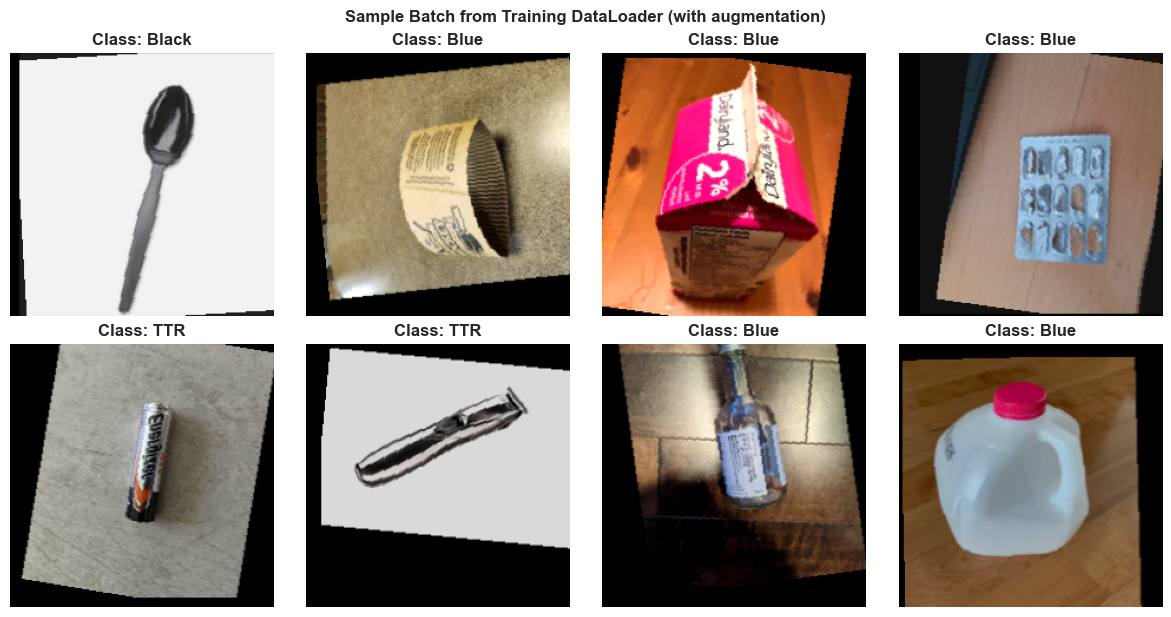

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Image dtype: torch.float32
Image range: [-2.118, 2.640]


In [78]:
# Visualize a batch of training data


# Get a batch from training loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Create index to class name mapping
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Display the first 8 images from the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(min(8, len(images))):
    # Denormalize and convert to numpy
    img = denormalize(images[i])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Clip to valid range

    axes[i].imshow(img)
    axes[i].set_title(f"Class: {idx_to_class[labels[i].item()]}", fontweight="bold")
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle(
    "Sample Batch from Training DataLoader (with augmentation)",
    fontsize=12,
    fontweight="bold",
    y=1.02,
)
plt.show()

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Image dtype: {images.dtype}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")

---

## 5. Model Architecture and Setup

### 5.1 Load Pretrained MobileNetV3

In [36]:


# Load pretrained MobileNetV3-Large
print("Loading MobileNetV3-Large with ImageNet pretrained weights...")
mobilenet = models.mobilenet_v3_large(weights='IMAGENET1K_V1')

print(f"Original classifier: {mobilenet.classifier}")
print(f"\nTotal parameters: {sum(p.numel() for p in mobilenet.parameters()):,}")

Loading MobileNetV3-Large with ImageNet pretrained weights...
Original classifier: Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

Total parameters: 5,483,032


### 5.2 Build Custom 3-Layer Classification Head

In [37]:
def build_custom_classifier(in_features: int, num_classes: int) -> nn.Sequential:
    return nn.Sequential(
        # Layer 1
        nn.Linear(in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        # Layer 2
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        # Layer 3 (Output layer)
        nn.Linear(256, num_classes),  # num_classes = 4
    )

In [38]:
# Get the input features from the last layer before the classifier
# MobileNetV3-Large classifier[0] is a Linear layer with 960 input features
first_layer = mobilenet.classifier[0]
if isinstance(first_layer, nn.Linear):
    in_features = first_layer.in_features  # 960 for MobileNetV3-Large
else:
    in_features = 960  # Default for MobileNetV3-Large

# Build custom 3-layer classification head
# Architecture: Input -> FC1(960->512) -> ReLU -> Dropout -> FC2(512->256) -> ReLU -> Dropout -> FC3(256->4)
custom_classifier = build_custom_classifier(
    in_features=in_features,
    num_classes=num_classes,
)

# Replace the original classifier
mobilenet.classifier = custom_classifier

# Move model to device
mobilenet = mobilenet.to(device)

print("Custom 3-layer classification head created!")
print(f"\nNew classifier architecture:")
print(mobilenet.classifier)
print(
    f"\nTrainable parameters in classifier: {sum(p.numel() for p in mobilenet.classifier.parameters()):,}"
)

Custom 3-layer classification head created!

New classifier architecture:
Sequential(
  (0): Linear(in_features=960, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=256, out_features=4, bias=True)
)

Trainable parameters in classifier: 625,924


### 5.3 Training Configuration

In [39]:
# Training hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.001
CHECKPOINT_DIR = Path("../models")
SAVE_EVERY = 5  # Save checkpoint every N epochs
EARLY_STOP_PATIENCE = 15  # Stop if no improvement for 15 epochs
WEIGHT_DECAY = 0.0001  # L2 regularization to prevent overfitting

# Note: Loss function (criterion) is defined in section 5.4 with class weights

# Optimizer - use different learning rates for backbone and classifier
# Smaller LR for pretrained backbone, larger for new classifier
optimizer = optim.AdamW(
    [
        {
            "params": mobilenet.features.parameters(),
            "lr": LEARNING_RATE * 0.1,
            "weight_decay": 0,
        },  # Backbone: 10x smaller LR and weight decay
        {
            "params": mobilenet.classifier.parameters(),
            "lr": LEARNING_RATE,
            "weight_decay": WEIGHT_DECAY,
        },  # Classifier: full LR and weight decay
    ]
)  # Don't pass global weight_decay since we're using per-parameter-group settings

# Learning rate scheduler - reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-6
)

print("Training configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Learning Rate (Classifier): {LEARNING_RATE}")
print(f"- Learning Rate (Backbone): {LEARNING_RATE * 0.1}")
print(f"- Weight Decay: {WEIGHT_DECAY}")
print(f"- Early Stopping Patience: {EARLY_STOP_PATIENCE} epochs")
print(f"- Optimizer: AdamW with differential learning rates")
print(f"- Scheduler: ReduceLROnPlateau")
print(f"- Loss Function: CrossEntropyLoss")
print(f"- Checkpoint Directory: {CHECKPOINT_DIR}")

Training configuration:
- Epochs: 50
- Learning Rate (Classifier): 0.001
- Learning Rate (Backbone): 0.0001
- Weight Decay: 0.0001
- Early Stopping Patience: 15 epochs
- Optimizer: AdamW with differential learning rates
- Scheduler: ReduceLROnPlateau
- Loss Function: CrossEntropyLoss
- Checkpoint Directory: ..\models


## 6. Training Functions

### 6.1 Training Epoch Function

In [21]:
def train_epoch(
    model: nn.Module, 
    dataloader: DataLoader, 
    criterion: nn.Module, 
    optimizer: optim.Optimizer, 
    device: torch.device
) -> Dict[str, float]:
    """
    Train the model for one epoch.
    
    Returns:
        dict with average loss and accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f'  Batch [{batch_idx + 1}/{len(dataloader)}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100 * correct / total:.2f}%', end='\r')
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return {
        'loss': epoch_loss,
        'accuracy': epoch_acc
    }

print("Training epoch function created!")

Training epoch function created!


### 6.2 Validation Epoch Function

In [22]:
def validate_epoch(
    model: nn.Module, 
    dataloader: DataLoader, 
    criterion: nn.Module, 
    device: torch.device
) -> Dict[str, float]:
    """
    Validate the model for one epoch.
    
    Returns:
        dict with average loss and accuracy for the epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return {
        'loss': epoch_loss,
        'accuracy': epoch_acc
    }

print("Validation epoch function created!")

Validation epoch function created!


### 6.3 Checkpoint Saving Functions

In [23]:
def save_checkpoint(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    epoch: int, 
    train_loss: float, 
    val_loss: float, 
    val_acc: float, 
    filepath: Path
) -> None:
    """
    Save model checkpoint with training state.
    
    Args:
        model: The model to save
        optimizer: The optimizer state
        epoch: Current epoch number
        train_loss: Training loss
        val_loss: Validation loss
        val_acc: Validation accuracy
        filepath: Path to save the checkpoint
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_acc
    }
    
    # Create checkpoint directory if it doesn't exist
    filepath.parent.mkdir(parents=True, exist_ok=True)
    
    # Save checkpoint
    torch.save(checkpoint, filepath)
    print(f"✓ Checkpoint saved to {filepath}")

def load_checkpoint(
    filepath: Path, 
    model: nn.Module, 
    optimizer: Optional[optim.Optimizer] = None
) -> int:
    """
    Load model checkpoint and restore training state.
    
    Args:
        filepath: Path to the checkpoint file
        model: Model to load weights into
        optimizer: Optional optimizer to restore state
    
    Returns:
        The epoch number from the checkpoint
    """
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f"✓ Checkpoint loaded from {filepath}")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Validation Accuracy: {checkpoint['val_accuracy']:.2f}%")
    
    return checkpoint['epoch']

print("Checkpoint functions created!")

print("- save_checkpoint(): Save model and training state")
print("- load_checkpoint(): Load model from checkpoint")

Checkpoint functions created!
- save_checkpoint(): Save model and training state
- load_checkpoint(): Load model from checkpoint


## 7. Main Training Loop

In [24]:
torch.cuda.empty_cache()  # Clear GPU memory before training

In [25]:
# Calculate class weights to handle imbalance
# Formula: weight = total_samples / (num_classes * samples_per_class)

# Get class distribution from training set
class_sample_counts = []
for class_idx in range(num_classes):
    # Count samples for each class
    count = sum(1 for _, label in train_dataset if label == class_idx)
    class_sample_counts.append(count)

total_samples = sum(class_sample_counts)

# Calculate weights (inverse frequency)
class_weights = []
for count in class_sample_counts:
    weight = total_samples / (num_classes * count)
    class_weights.append(weight)

# Convert to tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class Imbalance Analysis:")
print("=" * 60)
for i, class_name in enumerate(class_names):
    print(
        f"{class_name:<15} Samples: {class_sample_counts[i]:<8} Weight: {class_weights[i]:.4f}"
    )
print("=" * 60)
print(f"\nClass weights will penalize majority class errors less")
print(f"and minority class errors more, balancing the learning.\n")

# Update loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"✓ CrossEntropyLoss updated with class weights")

Class Imbalance Analysis:
Black           Samples: 2382     Weight: 1.2264
Blue            Samples: 4856     Weight: 0.6016
Green           Samples: 2331     Weight: 1.2532
TTR             Samples: 2116     Weight: 1.3806

Class weights will penalize majority class errors less
and minority class errors more, balancing the learning.

✓ CrossEntropyLoss updated with class weights


In [26]:
# Training history tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

# Best model tracking
best_val_acc = 0.0
best_epoch = 0
patience_counter = 0

# Training start time
start_time = time.time()
print(f"🚀 Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    
    print(f"\nEpoch [{epoch}/{EPOCHS}]")
    print("-" * 80)
    
    # Train
    train_metrics = train_epoch(mobilenet, train_loader, criterion, optimizer, device)
    
    # Validate
    val_metrics = validate_epoch(mobilenet, val_loader, criterion, device)
    
    # Update learning rate based on validation loss
    scheduler.step(val_metrics['loss'])
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save metrics
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['learning_rates'].append(current_lr)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print epoch summary
    print(f"\n  Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}%")
    print(f"  Val Loss:   {val_metrics['loss']:.4f} | Val Acc:   {val_metrics['accuracy']:.2f}%")
    print(f"  LR: {current_lr:.6f} | Time: {epoch_time:.2f}s")
    
    # Save periodic checkpoint
    if epoch % SAVE_EVERY == 0:
        checkpoint_path = CHECKPOINT_DIR / f"mobilenetv3_epoch_{epoch}.pth"
        save_checkpoint(
            mobilenet, optimizer, epoch,
            train_metrics['loss'], val_metrics['loss'], val_metrics['accuracy'],
            checkpoint_path
        )
    
    # Save best model
    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        best_epoch = epoch
        patience_counter = 0
        
        # Save best model
        best_model_path = CHECKPOINT_DIR / "mobilenetv3_best.pth"
        save_checkpoint(
            mobilenet, optimizer, epoch,
            train_metrics['loss'], val_metrics['loss'], val_metrics['accuracy'],
            best_model_path
        )
        print(f"  🌟 New best model! Validation accuracy: {best_val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")
    
    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n⚠️  Early stopping triggered! No improvement for {EARLY_STOP_PATIENCE} epochs.")
        break

# Training complete
total_time = time.time() - start_time
print("\n" + "=" * 80)
print(f"✅ Training completed!")
print(f"Total time: {total_time / 60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print("=" * 80)

🚀 Starting training at 2026-02-14 15:46:09

Epoch [1/50]
--------------------------------------------------------------------------------
  Batch [360/366], Loss: 0.7530, Acc: 65.17%
  Train Loss: 0.8321 | Train Acc: 65.20%
  Val Loss:   0.6834 | Val Acc:   72.91%
  LR: 0.000100 | Time: 572.38s
✓ Checkpoint saved to ..\models\mobilenetv3_best.pth
  🌟 New best model! Validation accuracy: 72.91%

Epoch [2/50]
--------------------------------------------------------------------------------
  Batch [360/366], Loss: 0.3531, Acc: 73.25%
  Train Loss: 0.6592 | Train Acc: 73.29%
  Val Loss:   0.6359 | Val Acc:   75.33%
  LR: 0.000100 | Time: 570.91s
✓ Checkpoint saved to ..\models\mobilenetv3_best.pth
  🌟 New best model! Validation accuracy: 75.33%

Epoch [3/50]
--------------------------------------------------------------------------------
  Batch [360/366], Loss: 0.2649, Acc: 76.50%
  Train Loss: 0.5794 | Train Acc: 76.46%
  Val Loss:   0.6449 | Val Acc:   74.40%
  LR: 0.000100 | Time: 573.

## 8. Training Results Visualization

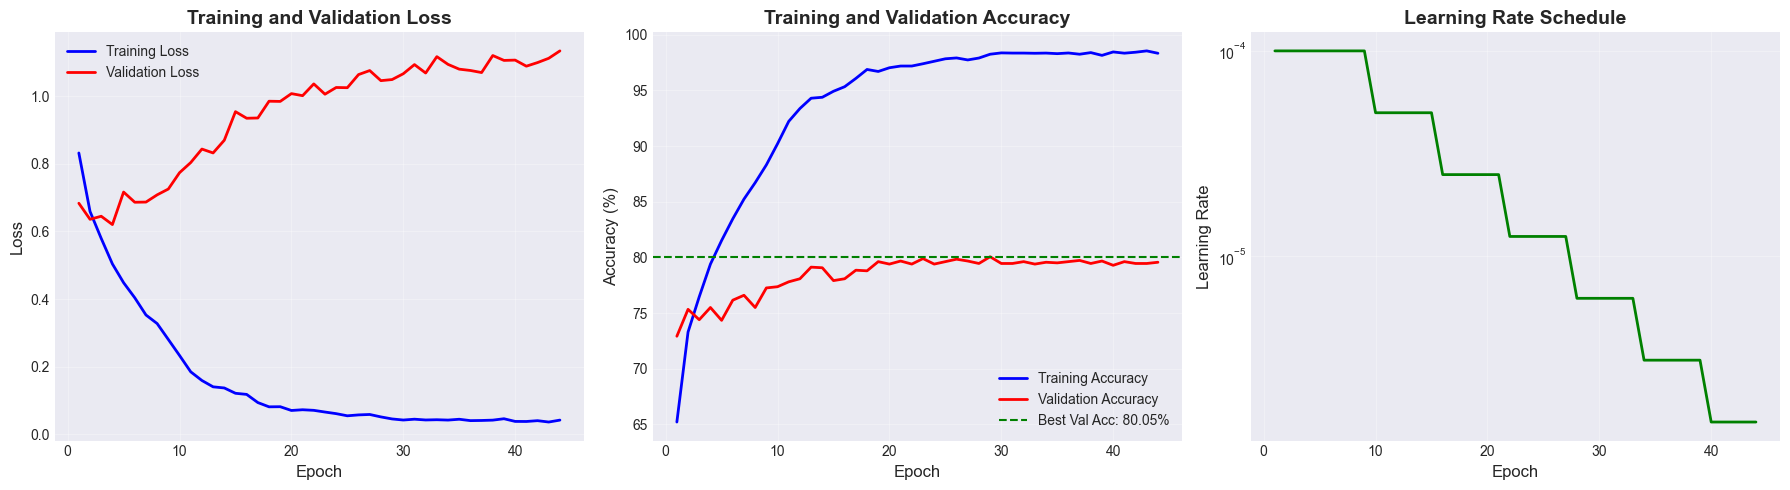

Training curves saved to ..\models\training_history.png


In [27]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot 1: Loss curves
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[1].axhline(y=best_val_acc, color='g', linestyle='--', label=f'Best Val Acc: {best_val_acc:.2f}%')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Learning rate schedule
axes[2].plot(epochs_range, history['learning_rates'], 'g-', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CHECKPOINT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved to {CHECKPOINT_DIR / 'training_history.png'}")

## 10. Model Evaluation Functions

### 10.1 Import Evaluation Libraries

In [79]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    confusion_matrix,
    classification_report
)

print("Evaluation libraries imported successfully!")

Evaluation libraries imported successfully!


### 10.2 Load Pre-trained Model Function

In [80]:
def load_pretrained_mobilenet_model(
    checkpoint_path: Path, num_classes: int = 4, device: torch.device | None = None
) -> nn.Module | models.MobileNetV3:
    """
    Load a pre-trained MobileNetV3 model from checkpoint.

    Args:
        checkpoint_path: Path to the checkpoint file (.pth)
        num_classes: Number of output classes (default: 4)
        device: Device to load model to (default: auto-detect)

    Returns:
        Loaded model ready for inference
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load base MobileNetV3-Large architecture
    model = models.mobilenet_v3_large(weights=None)  # Don't load ImageNet weights

    # Get input features for custom classifier
    first_layer = model.classifier[0]
    if isinstance(first_layer, nn.Linear):
        in_features = first_layer.in_features
    else:
        in_features = 960  # Default for MobileNetV3-Large

    # Build custom 3-layer classification head (same architecture as training)
    custom_classifier = build_custom_classifier(
        in_features=in_features,
        num_classes=num_classes,
    )

    # Replace classifier
    model.classifier = custom_classifier

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    # Note that when loading the checkpoint, we are also loading the weights of the classifier layer. So, we just have to make sure that we are loading the classifier layer in the correct order.
    model.load_state_dict(checkpoint["model_state_dict"])

    # Move to device and set to eval mode
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded from {checkpoint_path}")
    print(f"  Checkpoint epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"  Validation accuracy: {checkpoint.get('val_accuracy', 'N/A'):.2f}%")
    print(f"  Device: {device}")

    return model


print("load_pretrained_model() function created!")

load_pretrained_model() function created!


### 10.3 Comprehensive Model Evaluation Function

In [81]:
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    class_names: list[str],
    device: torch.device,
    plot_confusion_matrix: bool = True,
) -> Dict[str, Any]:
    """
    Comprehensive model evaluation with multiple metrics.

    Args:
        model: The model to evaluate
        dataloader: DataLoader for test/validation set
        class_names: List of class names for labeling
        device: Device to run evaluation on
        plot_confusion_matrix: Whether to plot confusion matrix heatmap

    Returns:
        Dictionary containing:
        - accuracy: Overall accuracy
        - macro_f1: Macro-averaged F1 score
        - per_class_precision: Precision for each class
        - inference_time: Average inference time per sample (ms)
        - confusion_matrix: Confusion matrix array
        - classification_report: Detailed per-class metrics
    """
    model.eval()

    all_predictions = []
    all_labels = []
    total_inference_time = 0.0
    num_samples = 0

    print("Running evaluation...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Move to device
            images = images.to(device)

            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            inference_time = time.time() - start_time

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Store results
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

            # Track inference time
            total_inference_time += inference_time
            num_samples += images.size(0)

            # Progress indicator
            if (batch_idx + 1) % 10 == 0:
                print(f"  Processed {num_samples} samples...", end="\r")

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    macro_f1 = f1_score(all_labels, all_predictions, average="macro")
    per_class_precision = precision_score(all_labels, all_predictions, average=None)
    avg_inference_time_ms = (total_inference_time / num_samples) * 1000  # Convert to ms
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        output_dict=True,
        digits=4,
    )

    result_string = f"""
{"\n" + "=" * 80}
EVALUATION RESULTS
{"=" * 80}
Total Samples: {num_samples}
Accuracy: {accuracy * 100:.2f}%
Average Inference Time: {avg_inference_time_ms:.2f} ms/sample
{"=" * 80}

Detailed Classification Report:
{classification_report(all_labels, all_predictions, target_names=class_names, digits=4)}
"""

    print(result_string)

    try:
        with open("../results/mobilenet_v3_classification_report.txt", "w") as fh:
            fh.write(result_string)
    except Exception as e:
        print("Failed to write results to file")

    # Plot confusion matrix
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))

        # Create heatmap
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={"label": "Count"},
            square=True,
            linewidths=1,
            linecolor="gray",
        )

        plt.title("Confusion Matrix", fontsize=16, fontweight="bold", pad=20)
        plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
        plt.ylabel("True Label", fontsize=12, fontweight="bold")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)

        # Add accuracy text
        plt.text(
            len(class_names) / 2,
            -0.5,
            f"Overall Accuracy: {accuracy * 100:.2f}%",
            ha="center",
            fontsize=12,
            fontweight="bold",
            color="darkblue",
        )

        plt.tight_layout()
        plt.show()

    # Return metrics dictionary
    return {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
        "per_class_precision": {
            class_names[i]: per_class_precision[i] for i in range(len(class_names))
        },
        "inference_time_ms": avg_inference_time_ms,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report,
    }


print("evaluate_model() function created!")

evaluate_model() function created!


### 10.4 Load and Evaluate Best Model on Test Set

In [82]:
CHECKPOINT_DIR = Path("../models")

✓ Model loaded from ..\models\mobilenetv3_best.pth
  Checkpoint epoch: 29
  Validation accuracy: 80.05%
  Device: cuda

Evaluating loaded model on test set...
Running evaluation...
  Processed 3200 samples...

EVALUATION RESULTS
Total Samples: 3452
Accuracy: 72.16%
Average Inference Time: 0.26 ms/sample

Detailed Classification Report:
              precision    recall  f1-score   support

       Black     0.6069    0.5557    0.5802       700
        Blue     0.7005    0.7782    0.7373      1091
       Green     0.8558    0.8122    0.8334       804
         TTR     0.7177    0.7001    0.7088       857

    accuracy                         0.7216      3452
   macro avg     0.7202    0.7116    0.7149      3452
weighted avg     0.7220    0.7216    0.7208      3452




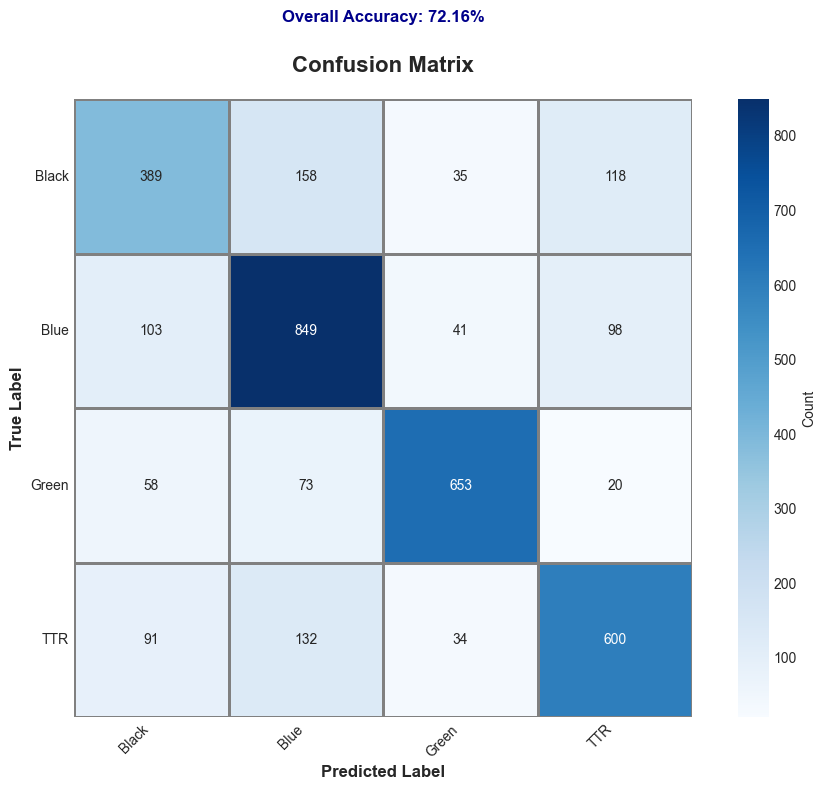

In [83]:
best_model_path = CHECKPOINT_DIR / "mobilenetv3_best.pth"
if best_model_path.exists():
    # Load the best model
    loaded_model = load_pretrained_mobilenet_model(
        checkpoint_path=best_model_path, num_classes=num_classes, device=device
    )

    # Evaluate on test set
    print("\nEvaluating loaded model on test set...")
    loaded_metrics = evaluate_model(
        model=loaded_model,
        dataloader=test_loader,
        class_names=class_names,
        device=device,
        plot_confusion_matrix=True,
    )
else:
    print(f"Best model checkpoint not found at {best_model_path}")
    print("Please train the model first or specify correct checkpoint path.")


## 11. Model Inference Demo on Test Set

### 11.1 Model Prediction Functions (Logits & Probabilities)

In [84]:
def get_predictions(
    model: nn.Module,
    images: torch.Tensor,
    return_type: Literal["logits", "probs", "both"] = "both",
) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Get model predictions with options for logits and/or probabilities.

    Args:
        model: The trained model
        images: Input images (batch)
        return_type: 'logits', 'probs', or 'both'

    Returns:
        Depending on return_type:
        - 'logits': raw logits (pre-softmax scores/weights)
        - 'probs': probability distribution (post-softmax)
        - 'both': tuple of (logits, probs)
    """
    model.eval()
    with torch.no_grad():
        # Get raw logits (these are the "weights" over classes before softmax)
        logits = model(images)

        # Apply softmax to get probability distribution
        probs = torch.softmax(logits, dim=1)

        if return_type == "logits":
            return logits
        elif return_type == "probs":
            return probs
        else:  # 'both'
            return logits, probs


# Example usage function
def predict_single_image(
    model: nn.Module, image_tensor: torch.Tensor
) -> Dict[str, Union[int, str, np.ndarray]]:
    """
    Predict a single image and return detailed results.

    Args:
        model: Trained model
        image_tensor: Preprocessed image tensor (C, H, W)

    Returns:
        dict with predicted class, logits, and probabilities
    """
    # Add batch dimension if needed
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    image_tensor = image_tensor.to(device)

    # Get both logits and probabilities
    logits, probs = get_predictions(model, image_tensor, return_type="both")

    # Get predicted class
    predicted_class = torch.argmax(probs, dim=1).item()

    return {
        "predicted_class_idx": predicted_class,
        "predicted_class_name": idx_to_class[predicted_class],
        "logits": logits.cpu().numpy()[0],  # Raw scores for each class
        "probabilities": probs.cpu().numpy()[0],  # Probability distribution
    }


print("Prediction functions created!")
print("- get_predictions(): Get logits and/or probabilities for a batch")
print("- predict_single_image(): Detailed prediction for single image")

Prediction functions created!
- get_predictions(): Get logits and/or probabilities for a batch
- predict_single_image(): Detailed prediction for single image


### 11.2 Test Model Predictions with Logits and Probabilities

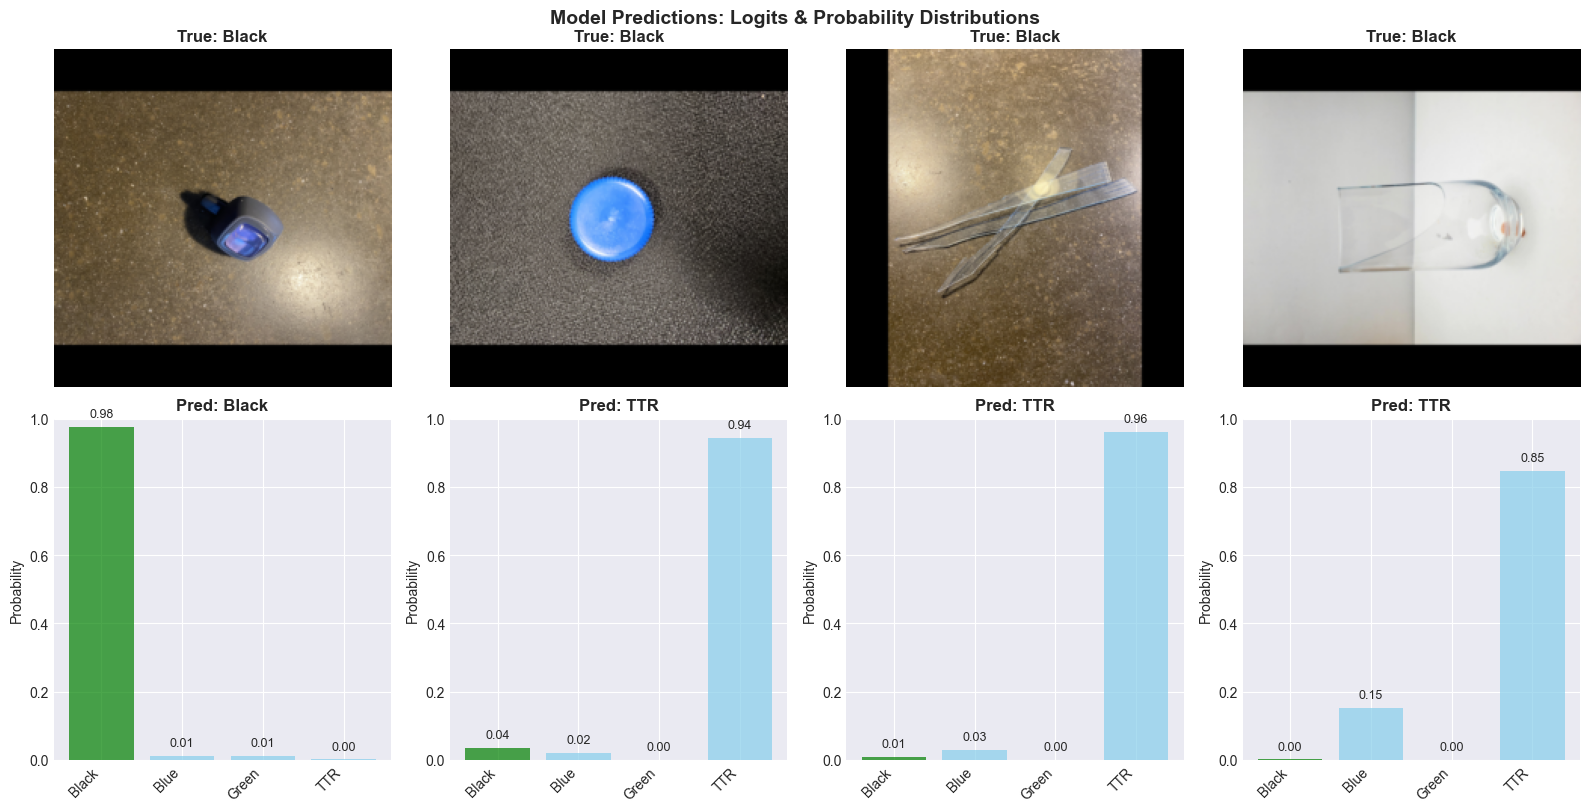


Detailed output for first test image:
True Label: Black

Raw Logits (pre-softmax weights):
  Black: 2.4938
  Blue: -1.9231
  Green: -1.9476
  TTR: -4.0573

Probability Distribution (post-softmax):
  Black: 0.9753 (97.53%)
  Blue: 0.0118 (1.18%)
  Green: 0.0115 (1.15%)
  TTR: 0.0014 (0.14%)

Predicted Class: Black
Confidence: 97.53%


In [85]:
# Get a test batch
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)
test_images = test_images.to(device)

# Get predictions with both logits and probabilities
logits, probs = get_predictions(loaded_model, test_images, return_type="both")

# Display results for first 4 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(test_images))):
    # Show image
    img = denormalize(test_images[i].cpu())
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    axes[0, i].imshow(img)
    axes[0, i].set_title(
        f"True: {idx_to_class[test_labels[i].item()]}", fontweight="bold"
    )
    axes[0, i].axis("off")

    # Show probability distribution
    prob_values = probs[i].cpu().numpy()
    logit_values = logits[i].cpu().numpy()

    x_pos = np.arange(num_classes)
    colors = [
        "green" if j == test_labels[i].item() else "skyblue" for j in range(num_classes)
    ]

    axes[1, i].bar(x_pos, prob_values, color=colors, alpha=0.7)
    axes[1, i].set_xticks(x_pos)
    axes[1, i].set_xticklabels(
        [idx_to_class[j] for j in range(num_classes)], rotation=45, ha="right"
    )
    axes[1, i].set_ylabel("Probability")
    axes[1, i].set_ylim([0, 1])
    axes[1, i].set_title(
        f"Pred: {idx_to_class[torch.argmax(probs[i]).item()]}", fontweight="bold"
    )

    # Add probability values on bars
    for j, v in enumerate(prob_values):
        axes[1, i].text(j, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.suptitle(
    "Model Predictions: Logits & Probability Distributions",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.show()

# Print detailed output for first image
print("\nDetailed output for first test image:")
print(f"True Label: {idx_to_class[test_labels[0].item()]}")
print(f"\nRaw Logits (pre-softmax weights):")
for i, class_name in enumerate([idx_to_class[j] for j in range(num_classes)]):
    print(f"  {class_name}: {logits[0][i].item():.4f}")

print(f"\nProbability Distribution (post-softmax):")
for i, class_name in enumerate([idx_to_class[j] for j in range(num_classes)]):
    print(f"  {class_name}: {probs[0][i].item():.4f} ({probs[0][i].item()*100:.2f}%)")

print(f"\nPredicted Class: {idx_to_class[torch.argmax(probs[0]).item()]}")
print(f"Confidence: {torch.max(probs[0]).item()*100:.2f}%")